In [1]:
# imports 
import pandas as pd 
import numpy as np 

# visualizations
import matplotlib.pyplot as plt 
from matplotlib import style 
%matplotlib inline 
import seaborn as sns 
style.use('fivethirtyeight')

# stats
import statsmodels.api as sm 

# modeling 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# evaluation metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# run time 
from datetime import datetime as dt

In [2]:
!ls data

2022_NYS_grad-rate.csv
cohort_gradrates_22


In [ ]:
## helper function to evaluate model running time 
#start = dt.now()
# process stuff
#running_secs = (dt.now() - start).seconds

In [3]:
# importing our data 
nys_gradrate_22 = pd.read_csv('data/2022_NYS_grad-rate.csv')

In [4]:
# reformating some column names
nys_gradrate_22 = nys_gradrate_22.rename(
    columns={'entity_cd':'beds_cd','entity_name':'school','subgroup_name':'subgroup'})

In [5]:
# looking at our data
nys_gradrate_22.head()

,beds_cd,school,year,subgroup,grad_rate
0,10100010034,Albany High School,2022,Hispanic or Latino,73.7
1,10100010034,Albany High School,2022,White,86.9
2,10100010034,Albany High School,2022,Multiracial,77.4
3,10100010034,Albany High School,2022,English Language Learner,70.4
4,10100010034,Albany High School,2022,Economically Disadvantaged,75.5


### ANOVA (Analysis of Variance) Between Schools 

ANOVA ("Analysis of Variance") is a statistical test used to determine whether there is **statistically significant difference** of an outcome (i.e., graduation rates) between three or more groups. (Note: just testing things) 

In [36]:
import researchpy as rp

In [8]:
nys_gradrate_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds_cd    4680 non-null   int64  
 1   school     4680 non-null   object 
 2   year       4680 non-null   int64  
 3   subgroup   4680 non-null   object 
 4   grad_rate  4680 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 182.9+ KB


In [37]:
rp.summary_cont(nys_gradrate_22.grad_rate)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,grad_rate,4680.0,85.0974,14.3692,0.21,84.6856,85.5092


In [38]:
rp.summary_cont(nys_gradrate_22['grad_rate'].groupby(nys_gradrate_22['subgroup']))

,N,Mean,SD,SE,95% Conf.,Interval
subgroup,,,,,,
American Indian or Alaska Native,15,82.0200,15.4433,3.9874,73.4678,90.5722
Asian or Native Hawaiian/Other Pacific Islander,272,95.6239,6.5690,0.3983,94.8397,96.4081
Black or African American,631,85.6162,14.7571,0.5875,84.4625,86.7698
Economically Disadvantaged,1166,85.0009,13.2655,0.3885,84.2387,85.7631
English Language Learner,270,70.9196,14.4079,0.8768,69.1933,72.6460
Hispanic or Latino,742,84.1911,14.9841,0.5501,83.1112,85.2710
Multiracial,54,89.1148,10.2780,1.3987,86.3095,91.9202
Students with Disabilities,748,78.1086,15.2341,0.5570,77.0151,79.2021
White,782,93.3832,6.3253,0.2262,92.9392,93.8273


In [39]:
import scipy.stats as stats

In [40]:
# conducting a one-way ANOVA between student subgroups and graduation rates
stats.f_oneway(nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='American Indian or Alaska Native'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Asian or Native Hawaiian/Other Pacific Islander'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Black or African American'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Economically Disadvantaged'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='English Language Learner'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Hispanic or Latino'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Multiracial'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Students with Disabilities'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='White'],)

F_onewayResult(statistic=130.45973071336795, pvalue=3.696850480067743e-198)

In [11]:
from statsmodels.formula.api import ols 

In [12]:
subgroup_lm = ols('grad_rate ~ C(subgroup)', nys_gradrate_22).fit()

In [16]:
aov_results = sm.stats.anova_lm(subgroup_lm,typ=2)
aov_results

,sum_sq,df,F,PR(>F)
C(subgroup),176439.445105,8.0,130.459731,3.696850e-198
Residual,789658.084126,4671.0,NaN,NaN


In [17]:
school_lm = ols('grad_rate ~ C(school)', nys_gradrate_22).fit()

In [18]:
aov_results2 = sm.stats.anova_lm(school_lm, typ=1)
aov_results2

,df,sum_sq,mean_sq,F,PR(>F)
C(school),1239.0,748158.585707,603.840666,9.531164,0.0
Residual,3440.0,217938.943524,63.354344,NaN,NaN


In [143]:
aov_mdl = ols('grad_rate ~ C(school) + C(subgroup) + C(school):C(subgroup)', nys_gradrate_22).fit()
sm.stats.anova_lm(aov_mdl, typ=2)

C:\Users\Kevin\anaconda3\envs\nys-ell-gradrate\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1239, but rank is 15
  warnings.warn('covariance of constraints does not have full '
C:\Users\Kevin\anaconda3\envs\nys-ell-gradrate\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\Kevin\anaconda3\envs\nys-ell-gradrate\Lib\site-packages\numpy\linalg\linalg.py:2027: RuntimeWarning: overflow encountered in divide
  s = divide(1, s, where=large, out=s)
C:\Users\Kevin\anaconda3\envs\nys-ell-gradrate\Lib\site-packages\numpy\linalg\linalg.py:2030: RuntimeWarning: invalid value encountered in multiply
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))
C:\Users\Kevin\anaconda3\envs\nys-ell-gradrate\Lib\si

,sum_sq,df,F,PR(>F)
C(school),2.682025e+07,1239.0,339.774435,0.000002
C(subgroup),8.704424e+02,8.0,1.707848,0.272082
C(school):C(subgroup),NaN,9912.0,NaN,NaN
Residual,3.185450e+02,5.0,NaN,NaN


## Linear Mixed Effects Model 

### LMER Model (w. All Data) 

In [6]:
import statsmodels.formula.api as smf

Our first model will attempt to better understand how graduation rates relate to student subgroup while controlling for the effects of `School`. To test things, we'll start of using the entire dataset because our dataset is small. 

In [21]:
# linear mixed effects on entire dataset -- no train-test split 
md = smf.mixedlm("grad_rate ~ subgroup", nys_gradrate_22, groups=nys_gradrate_22["school"])
mdf = md.fit()
print(mdf.summary())

                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                grad_rate  
No. Observations:                  4680                   Method:                            REML       
No. Groups:                        1240                   Scale:                             35.3361    
Min. group size:                   1                      Log-Likelihood:                    -16645.1300
Max. group size:                   12                     Converged:                         Yes        
Mean group size:                   3.8                                                                  
--------------------------------------------------------------------------------------------------------
                                                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------

Our mixed-effects model returns some key results, namely that: 

At $\alpha$ = .01...

- The subgroups: `Asian or Native Hawaiian/Other Pacific Islander`, `English Language Learner`, `Multiracial`, `Students with Disabilities`, `White` have a statistically significant effect in graduation rate. 

<Axes: xlabel='residuals', ylabel='Count'>

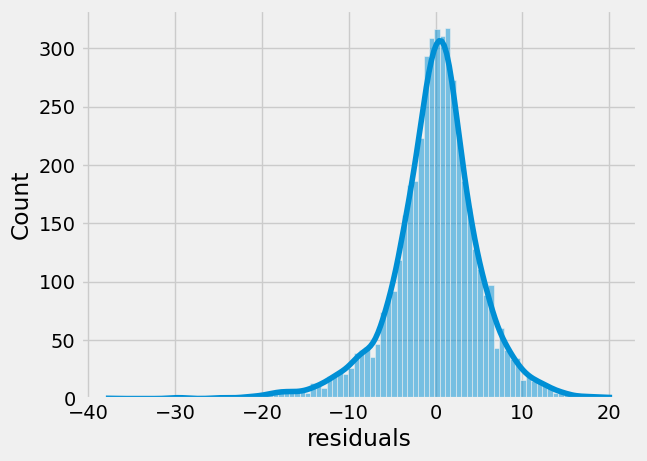

In [31]:
# evaluating our model by plotting the residuals  

grad_rates_22 = pd.DataFrame()
grad_rates_22["residuals"] = mdf.resid.values
grad_rates_22["predicted"] = mdf.fittedvalues

# plotting a residual plot
sns.histplot(grad_rates_22, x='residuals',kde=True)

<Axes: xlabel='predicted', ylabel='residuals'>

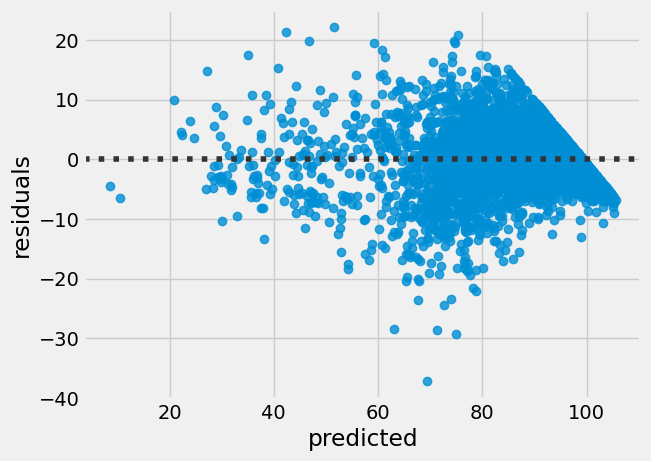

In [35]:
sns.residplot(grad_rates_22, x='predicted',y='residuals')

In [ ]:
# AIC & BIC -> log likelihood + penalty 

Next, we'll evaluate the relationship between `School` and `grad_rate` while controlling for the effects of `subgroup`

In [15]:
# schools as groups 

md = smf.mixedlm("grad_rate ~ school", nys_gradrate_22, groups=nys_gradrate_22["subgroup"])
mdf = md.fit()
print(mdf.summary())

                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             grad_rate  
No. Observations:             4680                Method:                         REML       
No. Groups:                   9                   Scale:                          35.3582    
Min. group size:              15                  Log-Likelihood:                 -11789.0100
Max. group size:              1166                Converged:                      Yes        
Mean group size:              520.0                                                          
---------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                       79.032    3.115  25.374 0.000  72.927  8

### LMER Model w. Train-Test Split

**Fixed Effect** == graduation rates 

**Random Effects** == school + student subgroup

In [7]:
# splitting data 
X = nys_gradrate_22.drop(columns=['beds_cd','year'])

X_train, X_test = train_test_split(X, test_size=0.2)

In [8]:
X_train.shape, X_test.shape

((3744, 3), (936, 3))

In [9]:
# linear mixed effect with 
# structure = "target variable ~ predictor variable"
base_md = smf.mixedlm("grad_rate ~ subgroup", X_train, groups= X_train["school"])
base_mdf = base_md.fit()
print(base_mdf.summary())

                                  Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 grad_rate  
No. Observations:                 3744                    Method:                             REML       
No. Groups:                       1207                    Scale:                              36.0972    
Min. group size:                  1                       Log-Likelihood:                     -13511.6613
Max. group size:                  9                       Converged:                          Yes        
Mean group size:                  3.1                                                                    
---------------------------------------------------------------------------------------------------------
                                                             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------

In [10]:
# getting our predictions 
preds = base_mdf.predict(X_test.drop(columns=['grad_rate']))

# MAE
mean_absolute_error(X_test.grad_rate, preds)

9.390891591649252

In [16]:
base_mdf.fe_params

Intercept                                                      88.258458
subgroup[T.Asian or Native Hawaiian/Other Pacific Islander]     3.371598
subgroup[T.Black or African American]                          -0.937869
subgroup[T.Economically Disadvantaged]                         -3.017940
subgroup[T.English Language Learner]                          -14.846380
subgroup[T.Hispanic or Latino]                                 -3.984535
subgroup[T.Multiracial]                                        -1.566183
subgroup[T.Students with Disabilities]                        -10.106319
subgroup[T.White]                                               3.002478
dtype: float64

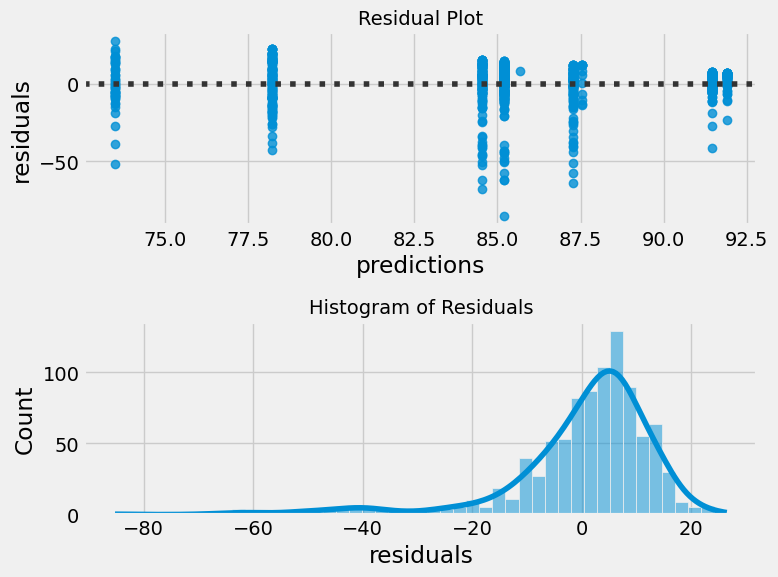

In [130]:
# creating a new dataframe to house our predictions and residuals 
baseline_mdf = pd.DataFrame()
baseline_mdf['predictions'] = preds
baseline_mdf['y_true'] = X_test.grad_rate
baseline_mdf['residuals'] = baseline_mdf.y_true - baseline_mdf.predictions 

# plotting the residual plot and histogram of residuals
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=False, sharey=False)
axs[0].set_title('Residual Plot', fontsize=14)
axs[0] = sns.residplot(baseline_mdf, x='predictions', y='residuals', ax = axs[0])

# plotting histogram of residuals 
axs[1].set_title('Histogram of Residuals', fontsize=14)
axs[1] = sns.histplot(baseline_mdf, x='residuals',kde=True)
plt.tight_layout()
plt.show()

#### LMER with Two Random Effects 

In [18]:
# linear mixed effect with 
# structure = "target variable ~ predictor variable" + random effect of school 
base_md2 = smf.mixedlm("grad_rate ~ subgroup", X_train, groups= X_train["school"],re_formula='~subgroup')
base_mdf2 = base_md2.fit()

C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Li

                                                         Mixed Linear Model Regression Results
Model:                                            MixedLM                                Dependent Variable:                                grad_rate  
No. Observations:                                 3744                                   Method:                                            REML       
No. Groups:                                       1207                                   Scale:                                             7.9786     
Min. group size:                                  1                                      Log-Likelihood:                                    -12856.2459
Max. group size:                                  9                                      Converged:                                         No         
Mean group size:                                  3.1                                                                                            

In [20]:
base_mdf2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                         Mixed Linear Model Regression Results
=======================================================================================================================================================
Model:                                            MixedLM                                Dependent Variable:                                grad_rate  
No. Observations:                                 3744                                   Method:                                            REML       
No. Groups:                                       1207                                   Scale:                                             7.9786     
Min. group size:                                  1                                      Log-Likelihood:                                    -12856.2459
Max. group size:                                  9                                      Converged:                                         No         
Mean group size:                                  3.1                                                                                                  
-------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                          Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                 86.572    1.116  77.541 0.000  84.384  88.760
subgroup[T.Asian or Native Hawaiian/Other Pacific Islander]                                                6.333    1.146   5.527 0.000   4.088   8.579
subgroup[T.Black or African American]                                                                      0.573    1.109   0.517 0.605  -1.600   2.746
subgroup[T.Economically Disadvantaged]                                                                    -1.296    1.088  -1.191 0.234  -3.430   0.837
subgroup[T.English Language Learner]                                                                     -13.604    1.358 -10.016 0.000 -16.266 -10.942
subgroup[T.Hispanic or Latino]                                                                            -2.262    1.105  -2.046 0.041  -4.428  -0.095
subgroup[T.Multiracial]                                                                                    0.075    1.321   0.057 0.955  -2.513   2.664
subgroup[T.Students with Disabilities]                                                                    -8.524    1.131  -7.536 0.000 -10.741  -6.307
subgroup[T.White]                                                                                          5.446    1.099   4.955 0.000   3.292   7.600
Group Var                                                                                                 99.498    3.243                              
Group x subgroup[T.Asian or Native Hawaiian/Other Pacific Islander] Cov                                  -26.254    3.668                              
subgroup[T.Asian or Native Hawaiian/Other Pacific Islander] Var                                           13.851    6.168                              
Group x subgroup[T.Black or African American] Cov                                                         18.345    2.091                              
subgroup[T.Asian or Native Hawaiian/Other Pacific Islander] x subgroup[T.Black or African American] Cov   -4.588    3.905                              
subgroup[T.Black or African American] Var                                                                 23.107    3.085                              
Group x subgroup[T.Economically Disadvantaged] Cov      

### Random Forest Regressor 

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
# instead of OHE, trying frequency encoding 
nys_gradrate_22.beds_cd.unique()

array([ 10100010034,  10100860907,  10500010007, ..., 671501040002,
       680601060001, 680801040001], dtype=int64)

In [22]:
subgroup_norm = nys_gradrate_22.groupby('subgroup').size() / len(nys_gradrate_22)

In [23]:
gradrate_df = nys_gradrate_22.copy()
gradrate_df['subgroup'] = gradrate_df['subgroup'].apply(lambda x: subgroup_norm[x])
gradrate_df = gradrate_df.drop(columns=['school','year'])
gradrate_df.tail()

,beds_cd,subgroup,grad_rate
4675,671501040002,0.249145,88.1
4676,680601060001,0.167094,91.1
4677,680601060001,0.249145,88.6
4678,680801040001,0.167094,78.6
4679,680801040001,0.249145,68.8


In [29]:
# instantiating our model 
rfr = RandomForestRegressor(random_state=1210)
rfr

RandomForestRegressor(random_state=1210)

In [34]:
# splitting our dataset 
X = gradrate_df[['beds_cd','subgroup']]
y = gradrate_df.grad_rate

# splitting our data 
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.2)

In [36]:
# fitting our RFR model 
rfr.fit(X_train,y_train)

RandomForestRegressor(random_state=1210)

In [37]:
# getting our predictions
rfr_preds = rfr.predict(X_test)

In [53]:
# getting the R2 score 
print(f'Training Set R^2:')
print(rfr.score(X_train,y_train))
print('\n')
print(f'Test Set R^2:')
print(rfr.score(X_test,y_test))
print('\n')
print(f'Mean Absolute Error:')
print(mean_absolute_error(y_test, rfr_preds))
print('\n')
print(f'Mean Squared Error:')
print(mean_squared_error(y_test, rfr_preds))

Training Set R^2:
0.46328915504618884


Test Set R^2:
0.11531914942969701


Mean Absolute Error:
8.948070545987942


Mean Squared Error:
177.8046979676352


Very bad. But our model is simple and the dataset is small. 

### Gaussian Process + XGBoost

In [231]:
import gpboost as gpb

In [257]:
X1 = gradrate_df
pred_vars = ['beds_cd', 'subgroup']
# splitting our data 
X1_train,X1_test = train_test_split(X1, test_size=0.2)

In [260]:
gp_model = gpb.GPModel(group_data=X1_train[pred_vars],likelihood='gaussian')
data_bst = gpb.Dataset(data=X1_train[pred_vars], label=X1_train['grad_rate'])
params = {'learning_rate': 0.01, 'max_depth': 2, 'min_data_in_leaf': 10,
          'lambda_l2': 10, 'num_leaves': 2**10, 'verbose': 0}
nrounds = 100
gpbst = gpb.train(params=params, train_set=data_bst, gp_model=gp_model,num_boost_round=nrounds)

In [265]:
pred = gpbst.predict(data=X1_test[pred_vars], group_data_pred=X1_test[pred_vars],
                     predict_var=False,pred_latent=False)

In [269]:
y_pred = pred['response_mean']

# calculating the MSE hard code 
np.mean(X1_test['grad_rate'] - y_pred)**2

0.031013898985971605

In [270]:
gp_model.summary()

Covariance parameters (random effects):
              Param.
Error_term   36.4990
beds_cd     140.5697
subgroup     32.1910


In [271]:
mean_absolute_error(X1_test.grad_rate, y_pred)

5.100312795288068